# Building a Boardgame Recommender System for BoardGameGeek users

## Part 2: Modeling and evaluating recommendations
*by Timothy Tan*

---
>In part 1, we extracted the games and ratings data via webscraping and api calls to the Boardgamegeek website. In this section, we will be attempting to put these ratings through various models in order to generate recommendations for users on the website.

>To recap, we have 120,679 users and 1807 games forming a N x M matrix of 120,679 x 1807 with a total of 7.7 million ratings. I have only selected users that have rated at least 10 games or more. Our matrix sparsity is 3.54%.

>I will be utilizing both neighbourhood and latent factor models from the collaborative filtering approach to predict ratings for each user on the games he/she has yet to rate. For the neighbourhood method, I will be employing the use of the cosine similarity function. Matrix factorization will be accomplished via the SVD method as well as a Non-negative matrix factorization method utilizing alternating least squares to minimize the loss function.

>Offline evaluations will be conducted using RMSE and top 20 recommendations will be provided for individual users with at least 10 ratings. 



> The approach in general is as follows:
1. Acquire train and test sets
2. Normalize train set ratings
3. Fit train set on model instance
4. Make predictions on test set
5. Determine RMSE
6. Provide recommendations for specified user

> There may be some exceptions like for instance we do not fit a model with cosine similarity but in general this is the approach we will be adopting for each method

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sqlite3
from scipy import sparse
from sklearn.metrics import mean_squared_error

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.set_style('white')

## Getting the data in place through pickling and read.csv

In [2]:
df = pd.read_pickle('ratings_pickle')

In [39]:
df.shape

(120679, 1807)

In [40]:
df.head()

gameid,1,3,5,7,9,10,11,12,13,14,...,206718,206941,207336,207691,207830,209010,209685,209778,213893,219513
username,,,,,,,,,,,,,,,,,,,,,
mycroft,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,9.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-=Yod@=-,NaN,NaN,NaN,7.5,NaN,NaN,7.0,NaN,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-Johnny-,5.0,4.0,7.0,NaN,NaN,4.0,6.0,5.0,7.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-Loren-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-LucaS-,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
games = pd.read_csv('bgg_gamelist.csv')

In [213]:
games.head()

,gameid,gamename,nratings,gamerank
0,13,Catan,71279,251
1,822,Carcassonne,70895,130
2,30549,Pandemic,66881,64
3,36218,Dominion,58707,59
4,68448,7 Wonders,55341,37


## Creating the base class
> The Recommender class contains methods for preprocessing the data before modeling. The class takes in a ratings dataframe and allows one to create a sparse representation of it, train-test split it, normalize the training set, calculate mean by users and overall mean as well as obtaining the RMSE score for model evaluation.

In [4]:
class Recommender(object):
    '''
    A class for building a recommender model
    
    Params
    ======
    ratings : (Dataframe)
        User x Item matrix with corresponding ratings
        
    '''
    
    def __init__(self, ratings):
        self.ratings = ratings
    
    def create_sparse(self, ratings):
        '''
        Creates sparse matrices by filling NaNs
        with zeros first
        '''
        ratings_sparse = sparse.csr_matrix(ratings.fillna(0))
        return ratings_sparse
        
    def train_test_split(self, ratings_sparse, test_size='default', train_size=None, random_state=None):
        '''
        Splits ratings data into train and test sets. 
        This implementation ensures that each test set
        will have at least one rating from each user.
        
        Params
        ======
        ratings_sparse : (Sparse matrix)
            A sparse representation of the original matrix
        
        test_size : (int)
            An integer indicating number of random ratings 
            from each user to be allocated to the test set
        
        train_size : (int)
            An integer indicating number of random ratings
            from each user to be allocated to the train set
            
        random_state : (int)
            Random seed for reproducibility
        '''
        r = np.random.RandomState(random_state)
        
        if test_size == 'default':
            test_size = None
        if test_size is None and train_size is None:
            test_size = 1
        if test_size == float or train_size == float:
            raise ValueError('test_size or train_size must be a positive integer')
        if train_size is not None: 
            test_size = None
        
        if test_size is not None:
            train_set = self.ratings.copy().as_matrix()
            test_set = np.full(self.ratings.shape, np.nan)

            for idx, row in enumerate(ratings_sparse):
                #Get column ids based on random choice of available games in current user
                test_indices = r.choice(row.indices, test_size, replace=False)
                test_data = []
                for val in test_indices:
                    index = list(row.indices).index(val)
                    test_data.append(row.data[index])
                train_set[idx, test_indices] = np.nan
                test_set[idx, test_indices] = test_data
            train_set = pd.DataFrame(train_set, index=self.ratings.index, columns=self.ratings.columns)
            test_set = pd.DataFrame(test_set, index=self.ratings.index, columns=self.ratings.columns)
                
        else:
            test_set = self.ratings.as_matrix()
            train_set = np.full(self.ratings.shape, np.nan)
            
            for idx, row in enumerate(ratings_sparse):
                train_indices = r.choice(row.indices, train_size, replace=False)
                train_data = []
                for val in train_indices:
                    index = list(row.indices).index(val)
                    train_data.append(row.data[index])
                test_set[idx, train_indices] = np.nan
                train_set[idx, train_indices] = train_data
            train_set = pd.DataFrame(train_set, index=self.ratings.index, columns=self.ratings.columns)
            test_set = pd.DataFrame(test_set, index=self.ratings.index, columns=self.ratings.columns)
        
        assert self.ratings.notnull().sum().sum() == train_set.notnull().sum().sum() + test_set.notnull().sum().sum()
    
        return train_set, test_set
        
    
    def normalize(self, ratings_sparse):
        '''Normalizes each user by their mean. Accepts a sparse array'''
        ratings = np.zeros_like(self.ratings)
        for idx, i in enumerate(ratings_sparse):
            ratings[idx, i.indices] = i.data-i.data.mean()    
        return ratings
    
    def get_user_mean(self):
        '''Calculate mean rating values for each user'''
        mean = np.mean(self.ratings, axis=1)
        return mean
    
    def get_overall_mean(self, mean):
        '''
        Outputs mean of entire dataframe
        
        Params
        ======
        
        mean : (pd.Series or nd_array)
            Vector of user means across their ratings
        '''
        mean_all = np.mean(mean)
        return mean_all
    
    def get_baseline_rmse(self, test, mean_all):
        '''
        Ouputs the baseline rmse by comparing test 
        set ratings with the mean rating for each user
        
        Params
        ======
        
        test : (nd_array)
            Numpy array of test results
            
        test_sparse : (Sparse matrix)
            Sparse representation of test matrix
        
        mean_all : (float)
            Value of mean of entire ratings matrix
        '''
        actual = test[test.nonzero()].flatten()
        preds = [mean_all for val in test[test.nonzero()].flatten()]
        prediction = preds
        return np.sqrt(mean_squared_error(actual, prediction))
    
    def get_rmse(self, test, prediction):
        '''
        Returns the rmse score from a prediction result
        
        Params
        ======
        
        test : (nd_array
            Numpy array of test results
            
        prediction (nd_array)
            Predicted scores after training through model
        '''
        actual = test[test.nonzero()].flatten()
        prediction = prediction[prediction.nonzero()].flatten()
        return np.sqrt(mean_squared_error(actual, prediction))


## Neighbourhood method - Cosine similarity recommender
> Our first method to determine recommendations is by calculating the similarity between users and items. I have decided to employ the cosine similarity function owing to its favourable representation in the recommender systems community.

> A similarity matrix is first obtained between each item pair or user pair. A prediction function is then used to predict ratings for results held out in the test set in order to compare the accuracy through the RMSE loss function.

> In this case, we will only be utilizing item-item similarities as our neighborhood method of choice due to less intensive computation required.

> A child class was built off the Recommender class so as to be able to utilize some of its functions like calculating RMSE which will be used for all our models.

In [5]:
from sklearn.metrics.pairwise import cosine_similarity 

class CosineSim(Recommender):
    '''
    A Recommender class that uses the cosine similarity 
    function to recommend games
    
    Params
    ======
    ratings : (Dataframe)
        Ratings matrix
    '''
    def __init__(self, ratings):
        self.ratings = ratings
    
    def find_similarity(self, ratings_sparse, kind='item'):
        '''
        Finds the cosine similarity in either 
        item-item or user-user configurations
        of a sparse matrix
        
        Params
        ======
        ratings_sparse : (Sparse matrix)
            Sparse representation of ratings matrix
        
        kind : (string)
            Default is item for item-item similarity. 
            Other option is user for user-user similarity
        '''
        if kind == 'item':
            similarities = cosine_similarity(ratings_sparse.T)
        elif kind == 'user':
            similarities = cosine_similarity(ratings_sparse)
        return similarities
    
    def predict_for_test(self, train, test_sparse, similarity, kind='item'):
        '''
        Predicts the scores for games in test set
        
        Params
        ======
        train : (Dataframe)
            Dataframe of training set
            
        test_sparse : (Sparse matrix)
            Sparse representation of test set
            
        similarity : (nd_array)
            Similarity matrix of user-user or item-item pairs
            
        kind : (string)
            Default is 'item' for item-item predictions.
            Alternative is 'user' for user-user predictions
            
        '''
        prediction = np.zeros_like(train)

        if kind == 'item':
            train = train.fillna(0).as_matrix()
            for row, val in enumerate(test_sparse):
                for col in val.indices:
                    sim = similarity[col]
                    rated = train[row].nonzero()
                    prediction[row, col] = np.sum(sim[rated]*train[row][rated])/np.sum(np.abs(sim[rated]))

        elif kind == 'user':
            mean  = train.apply(np.mean, axis=1)
            std = train.apply(np.std, axis=1)

            for row, val in enumerate(test_sparse):
                avg_rating = mean.iloc[row]
                sim = similarity[row]
                ind_std = std.iloc[row]

                for col in val.indices:
                    prediction[row, col] = avg_rating + np.sum(sim*train.iloc[:, col])/np.sum(np.abs(sim))

        return prediction    
        
    def recommend(self, user, similarity, games, kind='item'):
        '''
        Recommends list of games to specified user
        
        Params
        ======
        user : (string)
            username with at least 10 ratings in database
            
        similarity : (nd_array)
            Similarity matrix of user-user or item-item pairs
            
        games : (Dataframe)
            Dataframe of game list
        
        kind : ('string)
            Default is 'item' for item-item predictions.
            Alternative is 'user' for user-user predictions
        '''
        preds = np.zeros_like(self.ratings.loc[user])

        if kind == 'item':
            ratings_array = self.ratings.fillna(0).as_matrix()
            person = ratings_array[self.ratings.index.get_loc(user)]
            rated = person.nonzero()[0]
            for idx in range(ratings_array.shape[1]):
                if idx not in rated:
                    sim = similarity[idx]
                    preds[idx] = np.sum(sim[rated]*person[rated])/np.sum(np.abs(sim[rated]))

        elif kind == 'user':

            rated = self.ratings.loc[user].dropna().index
            std = np.std(self.ratings.loc[user])
            mean  = np.mean(self.ratings.loc[user])
            sim = similarity[self.ratings.index.get_loc(user)]

            for idx, col in enumerate(ratings.columns):
                if col not in rated:
                    preds[idx] = mean + np.sum((sim*ratings[col]))/np.sum(np.abs(sim))

        predictions = pd.Series(preds, index=self.ratings.columns, name='predictions')
        recommendations = games.join(predictions, on='gameid')
        return recommendations.sort_values('predictions', ascending=False)

In [5]:
#Creating an instance of the Recommnder class
rec = Recommender(df)

In [6]:
#Creating a sparse matrix of the full data
df_sparse = rec.create_sparse(df)

In [7]:
#Performing train-test split 
%time train, test = rec.train_test_split(df_sparse, test_size=2, random_state=123)

CPU times: user 43.2 s, sys: 7.55 s, total: 50.8 s
Wall time: 53.8 s


In [8]:
#Create sparse matrix for training set
train_sparse = rec.create_sparse(train)

In [9]:
#Create sparse matrix for test set
test_sparse = rec.create_sparse(test)

### Similarity matrix formation

In [11]:
#Create an instance of the Cosine Similarity Recommender class
cossim = CosineSim(df)

> The first thing we should normally do is normalize the training set to account for variances in how users rate the games. We do not normalize the training set here as the cosine similarity function from sklearn already does it for us.

In [12]:
#Acquiring item-item similarity matrix
%time item_sims = cossim.find_similarity(train_sparse)

CPU times: user 5.83 s, sys: 357 ms, total: 6.19 s
Wall time: 6.3 s


### Predicting scores for test set

In [18]:
#Predicting the scores for test set
%time item_preds = cossim.predict_for_test(train, test_sparse, item_sims)

CPU times: user 36 s, sys: 5.92 s, total: 41.9 s
Wall time: 43.5 s


### Evaluation with RMSE

In [10]:
#Converting test set to an array
y = test.fillna(0).values

In [11]:
#Getting user means
mean = rec.get_user_mean()

In [22]:
#Calculating overall mean
overall_mean = rec.get_overall_mean(mean)
overall_mean

7.398810764577983

In [23]:
#Computing baseline error
baseline_error = rec.get_baseline_rmse(y, overall_mean)
baseline_error

1.4869803145678728

> Our baseline error is calculated based on imputing all values in the test set with the mean of the overall dataset of 7.3988. 

In [24]:
#Calculating the error
error_cos = cossim.get_rmse(y, item_preds)
error_cos

1.3339479358142938

> We can observe a decrease in the RMSE score of about 10% from baseline. This was calculated based on utilizing similarity scores of all item-item pairs. 

### Performing recommendations

> We will be performing recommendations for myself as I am an active user of the site and have rated quite a number of games (226 to be exact). We calculate the similarity matrix again, this time utilizing the entire dataset before making the predictions and provide recommendations for specific users

In [13]:
#Calculate item-item similarity matrix of entire ratings data
%time all_sims = cossim.find_similarity(df_sparse)

CPU times: user 5.9 s, sys: 343 ms, total: 6.24 s
Wall time: 6.4 s


In [14]:
pd.to_pickle(all_sims, 'cos_ii_sims_all_pickle')

In [16]:
#Perform recommendation for a specific user
%time me_cos = cossim.recommend('Hilaryg', all_sims, games)

CPU times: user 10.5 s, sys: 7.27 s, total: 17.7 s
Wall time: 22.6 s


In [17]:
#Observe top 20 recommendations
me_cos.head(20)

,gameid,gamename,nratings,gamerank,predictions
660,193037,Dead of Winter: The Long Night,3068,141,7.259520
1551,197831,Dark Souls: The Board Game,1181,1594,7.244522
478,175155,Forbidden Stars,4349,79,7.243415
78,170216,Blood Rage,16362,17,7.239952
245,205637,Arkham Horror: The Card Game,7676,19,7.235248
221,205059,Mansions of Madness: Second Edition,8527,20,7.234508
371,181279,Fury of Dracula (third edition),5512,146,7.233652
1103,172047,The Others,1760,565,7.232802
1408,181524,Masmorra: Dungeons of Arcadia,1326,965,7.232654
341,176189,Zombicide: Black Plague,5965,100,7.228349


> This list of games is quite an interesting one. I own one of the games (Cry Havoc) and have yet to play it but purchased it after performing intensive research. Several of the games like Dead of Winter, Viticulture and Scythe are in my wishlist. There are some games that I have looked at but have no interest in trying like Cash n Guns and Forbidden Stars. Most of the other games I am aware of but have not done deeper research and suggests that I should do so based on its recommendation.

> One thing interesting about this list is the range of games it provides. It does not include solely the top games as determined by the game rank but has a good mix from the top 600. In fact, Monikers, ranked 557, is one I have never heard of till now.

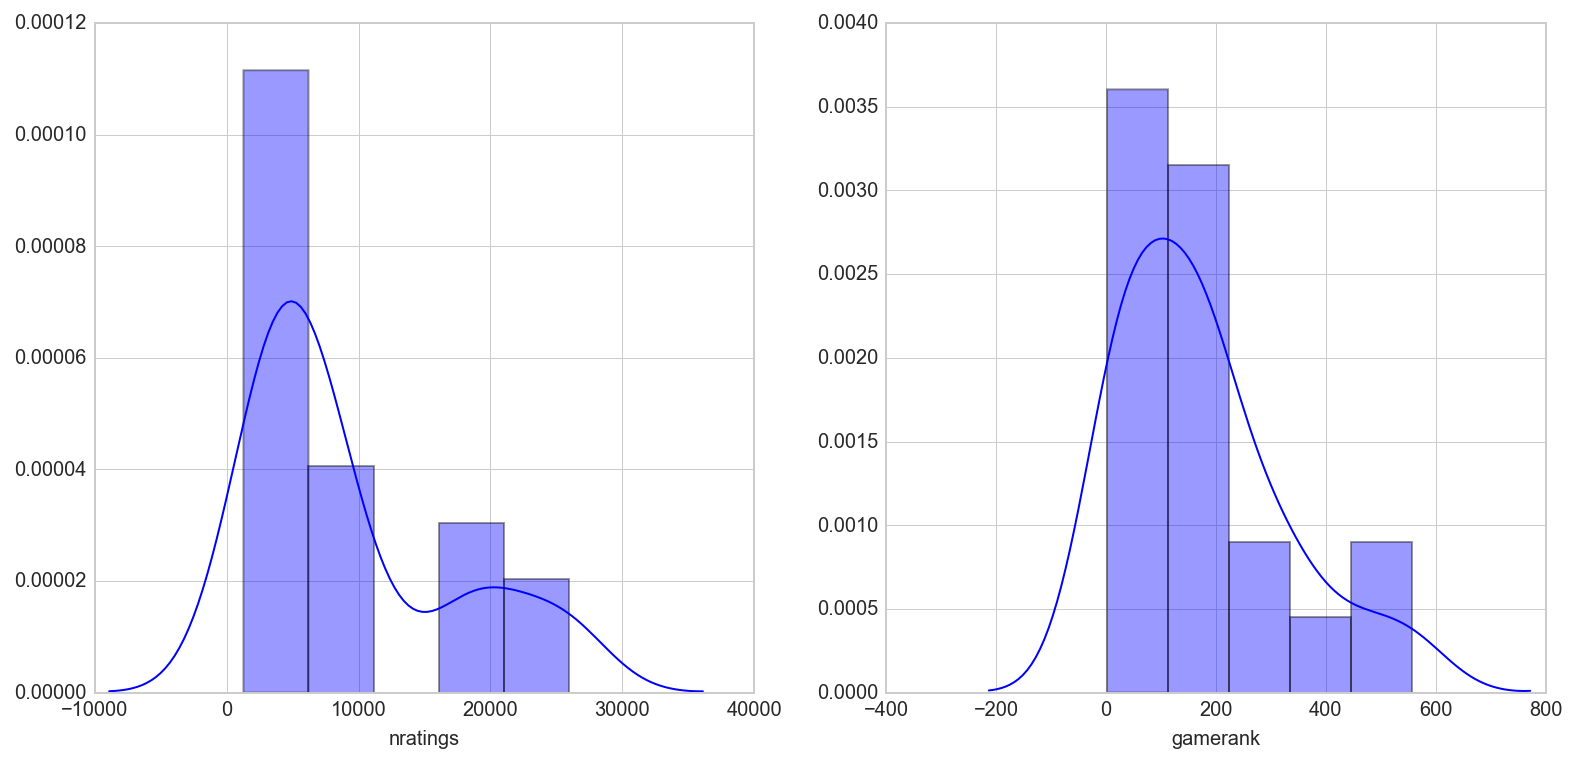

In [131]:
fig, ax = plt.subplots(1,2, figsize=(13,6))
sns.distplot(me_cos.head(20)['nratings'], ax=ax[0])
sns.distplot(me_cos.head(20)['gamerank'], ax=ax[1])
plt.show()

> Most of the games in this top 20 list have less than 5000 ratings which seems to suggest a rather good spread of game popularity in its recommendation. For reference, the maximum number of ratings for a game in our dataset is 70,000 and the least is 975. 

>The majority of the games recommended also lies between 1-200 in gamerank which suggests that the recommender is recommending me games that have a high approval rate with the user population. The spread is not too bad hitting games that rank in the 500s. This is more diverse than some lists recommended further down as we shall soon see. For reference, the top ranked game in our database is 1 while the least is 14344

## Latent Factor method - matrix factorization with SVD
> The latent factor method decomposes the sparse ratings matrix into a set of latent vectors for both users and items. These are low rank approximations of the original matrix and helps to address the issue of sparsity that is characteristic of any form of explicit rating data. 

> It should be understood that the latent space that is created by mapping both user and items onto is made up of item and user dimensions, some of which are explainable like theme and mechanics of the game to unexplainable concepts. Each user and item can be explained by some combination of these factors and therefore predictions of a user's preference for an item can be made through a simple dot product of the user's latent vector by the transpose of that item's corresponding latent vector.

> We explore this concept with the Singular Value Decomposition of the ratings matrix first. We build a child class from our base Recommender class to represent the SVD model 

In [12]:
from scipy.sparse.linalg import svds
class SVD(Recommender):
    '''
    A model for getting game recommendations by 
    calculating singular values through matrix
    decomposition into its latent factors
    
    Params
    ======
    ratings : (nd_array)
        Normalized ratings array
    '''
    def __init__(self, normed_ratings):
        self.normed_ratings = normed_ratings
        
    def train(self, k=50):
        '''
        Trains SVD model on ratings
        
        Params
        ======
        k : (int)
            Specifies number of latent factors to decompose into
        '''
        U, sigma, Vt = svds(self.normed_ratings, k)
        sigma = np.diag(sigma)
        return U, sigma, Vt
    
    def predict(self, U, sigma, Vt, test, mean):
        '''
        Outputs predictions for entire ratings matrix as well
        as for test set.
        
        Params
        ======
        test : (Dataframe)
            Test set pandas dataframe
        
        mean : (pd.Series)
            Vector of user means
        '''
        all_predictions = np.dot(np.dot(U, sigma), Vt) + mean.reshape(-1, 1)
        test_predictions = all_predictions[test.fillna(0).as_matrix().nonzero()]
        
        return all_predictions, test_predictions
    
    def recommend(self, ratings, user, games, predictions):
        '''
        Provides recommendations for the specified user
        
        Params
        ======
        user : (string)
            username with at least 10 ratings in database
        
        games : (Dataframe)
            Dataframe of game list
        
        predictions : (nd_array)
            predictions of entire ratings matrix
        '''
        user_idx = ratings.index.get_loc(user)
        preds = predictions[user_idx]
        rated = ratings.loc[user].fillna(0).as_matrix().nonzero()

        mask = np.ones_like(preds, dtype=bool)
        mask[rated] = False
        preds[~mask] = 0

        predictions = pd.Series(preds, index=ratings.columns, name='predictions')
        recommendations = games.join(predictions, on='gameid')
        return recommendations.sort_values('predictions', ascending=False)

### Normalize, instantiate and train

In [13]:
#Normalize training set
train_normed = rec.normalize(train_sparse)

In [14]:
#Instatiate SVD class
svd_train = SVD(train_normed)

In [15]:
#Train SVD model
%time U, sigma, Vt = svd_train.train(k=50)

CPU times: user 1min 26s, sys: 1.9 s, total: 1min 28s
Wall time: 1min 20s


> Our default number of latent factors is set to k=50

### Obtain predictions for test set

In [16]:
#Make predictions for test set
%time all_preds_svd50_train, test_preds_svd50 = svd_train.predict(U, sigma, Vt, test, mean)

/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:42: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


CPU times: user 23.2 s, sys: 15.3 s, total: 38.6 s
Wall time: 56.2 s


In [38]:
#Pickle predictions
pd.to_pickle(all_preds_svd50, 'svd50preds_pickle')

### Evaluate RMSE

In [17]:
#Evaluate RMSE for k=50
error_svd50 = svd_train.get_rmse(y, test_preds_svd50)
error_svd50

1.2861092502817428

> This value is 3% less than the value calculated for the Cosine Similarity method. 

### Recommend games

In [31]:
#Normalize df
df_normed = rec.normalize(df_sparse)

In [32]:
#Instantiate SVD model on entire df
svd = SVD(df_normed)

In [32]:
#Train SVD model on entire df
%time U, sigma, Vt = svd.train()

CPU times: user 1min 26s, sys: 1.23 s, total: 1min 27s
Wall time: 47.2 s


In [33]:
#Predict for entire df
%time all_preds_svd50, test_preds_svd50 = svd.predict(U, sigma, Vt, test, mean)

/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:42: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


CPU times: user 20.6 s, sys: 11.5 s, total: 32.2 s
Wall time: 40.1 s


In [34]:
#Pickle predictions
pd.to_pickle(all_preds_svd50, 'svd50preds_pickle')

In [45]:
#Recommend games for a specific user
%time me_svd_50 = svd.recommend(df, 'Hilaryg', games, all_preds_svd50)

CPU times: user 10.8 ms, sys: 35.9 ms, total: 46.6 ms
Wall time: 113 ms


In [46]:
#Displaying top 20 games with k=50
me_svd_50.head(20)

,gameid,gamename,nratings,gamerank,predictions
19,110327,Lords of Waterdeep,31175,44,8.197254
69,146021,Eldritch Horror,17877,42,7.720546
129,146508,T.I.M.E Stories,12468,35,7.441737
91,104162,Descent: Journeys in the Dark (Second Edition),15637,67,7.374680
26,84876,The Castles of Burgundy,27173,10,7.287204
221,205059,Mansions of Madness: Second Edition,8527,20,7.254821
131,164153,Star Wars: Imperial Assault,12300,21,7.248716
10,70323,King of Tokyo,39195,196,7.236951
62,96848,Mage Knight Board Game,19449,16,7.206660
15,178900,Codenames,34348,36,7.205886


> This list of games seem to be restricted to games within the top 200 or so. As it is, I am aware of all the games and have variations of some of the games listed such as Ticket to Ride: Europe and Dominion: Intrigue. I actually rate their sister games really highly which is why they appear.

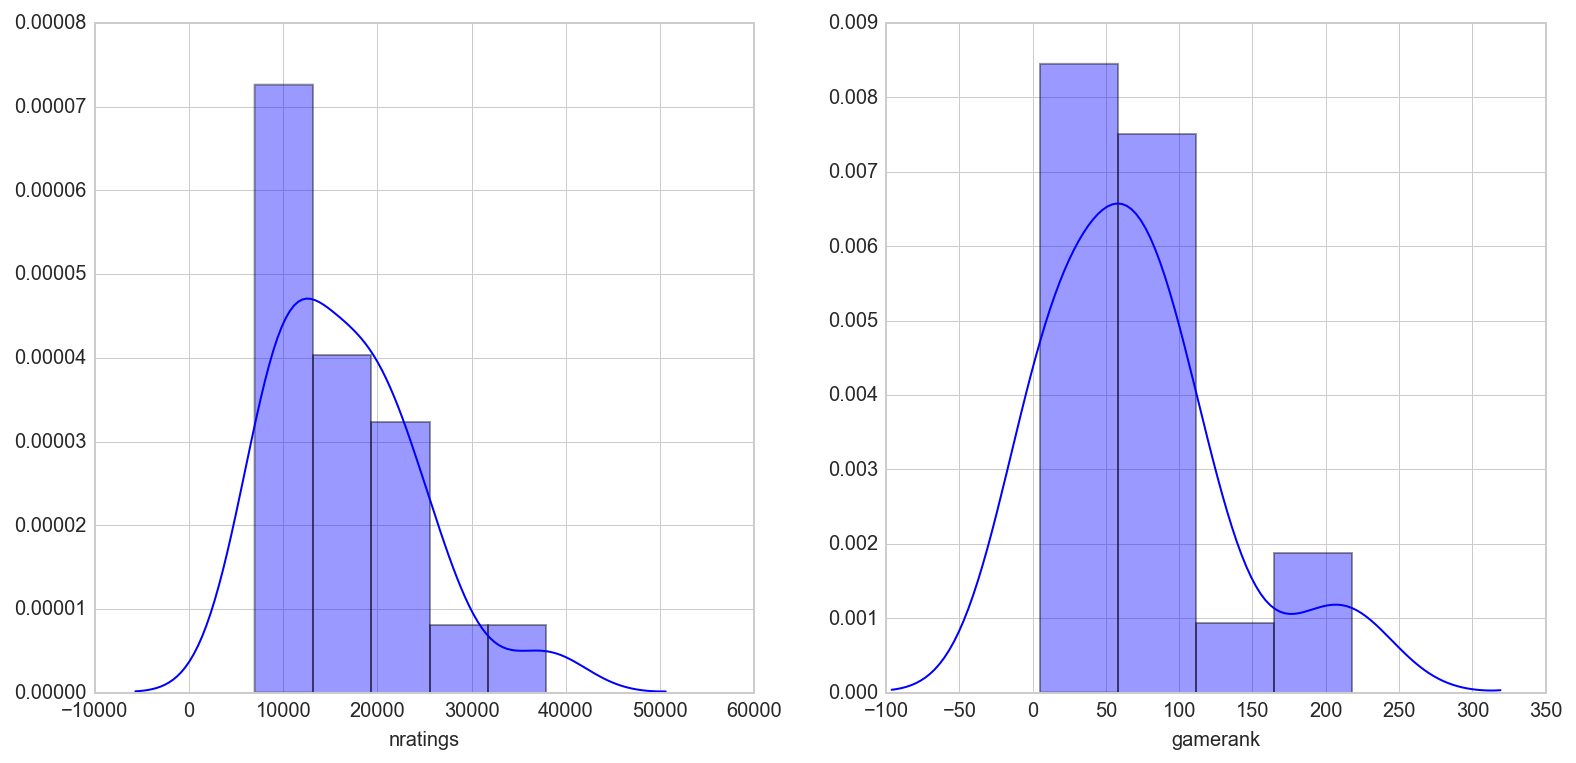

In [132]:
fig, ax = plt.subplots(1,2, figsize=(13,6))
sns.distplot(me_svd_50.head(20)['nratings'], ax=ax[0])
sns.distplot(me_svd_50.head(20)['gamerank'], ax=ax[1])
plt.show()

>While the maximum number of ratings was in the 20,000s for the cosine similarity model, the SVD model is giving me games that hit the high 30,000s in number of ratings. A look at the gamerank distribution also shows that the games fall between ranks 1-200 which suggests less diversity from the top-ranked games.

> Let's look at the results for changing the number of latent factors starting with k=100

In [18]:
#Train SVD model with k=100
%time U, sigma, Vt = svd_train.train(k=100)

CPU times: user 2min 16s, sys: 6.28 s, total: 2min 22s
Wall time: 1min 18s


In [19]:
#Make predictions
%time all_preds_svd100_train, test_preds_svd100 = svd_train.predict(U, sigma, Vt, test, mean)

/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:42: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


CPU times: user 21.6 s, sys: 11.8 s, total: 33.5 s
Wall time: 38.2 s


In [20]:
#Evaluate RMSE for k=100
error_svd_100 = svd_train.get_rmse(y, test_preds_svd100)
error_svd_100

1.2954613798828805

> The result is slightly worse than k=50 but still remains better than the RMSE for cosine similarity

In [42]:
#Train SVD model on entire df
%time U, sigma, Vt = svd.train(k=100)

CPU times: user 2min 39s, sys: 3.91 s, total: 2min 43s
Wall time: 1min 30s


In [43]:
#Predict for entire df
%time all_preds_svd100, test_preds_svd100 = svd.predict(U, sigma, Vt, test, mean)

/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:42: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


CPU times: user 21.6 s, sys: 9.69 s, total: 31.3 s
Wall time: 34.7 s


In [44]:
#Pickle predictions
pd.to_pickle(all_preds_svd100, 'svd100preds_pickle')

In [50]:
#Recommend games for a specific user
%time me_svd_100 = svd.recommend(df, 'Hilaryg', games, all_preds_svd100)

CPU times: user 6.48 ms, sys: 3.91 ms, total: 10.4 ms
Wall time: 9.5 ms


In [51]:
#Displaying top 20 games with k=100
me_svd_100.head(20)

,gameid,gamename,nratings,gamerank,predictions
32,173346,7 Wonders Duel,24654,9,7.573619
261,1115,Poker,7221,837,7.413376
82,132531,Roll for the Galaxy,16061,49,7.409192
112,154203,Imperial Settlers,13559,109,7.394173
86,123260,Suburbia,15805,82,7.342555
98,37046,Ghost Stories,14862,173,7.302493
101,155426,Castles of Mad King Ludwig,14629,68,7.300681
104,181304,Mysterium,14520,132,7.270232
41,70919,Takenoko,21794,186,7.223309
151,102652,Sentinels of the Multiverse,11565,239,7.194020


> Most of the games recommended come from the top 100 games. One big surprise here is that tic-tac-toe was actually recommended. A quick check reveals that it is the bottom-ranked game from the 1807 in our dataset. The list is really different from the previous 2 but nothing I have not seen or heard before. Not much serendipity here.

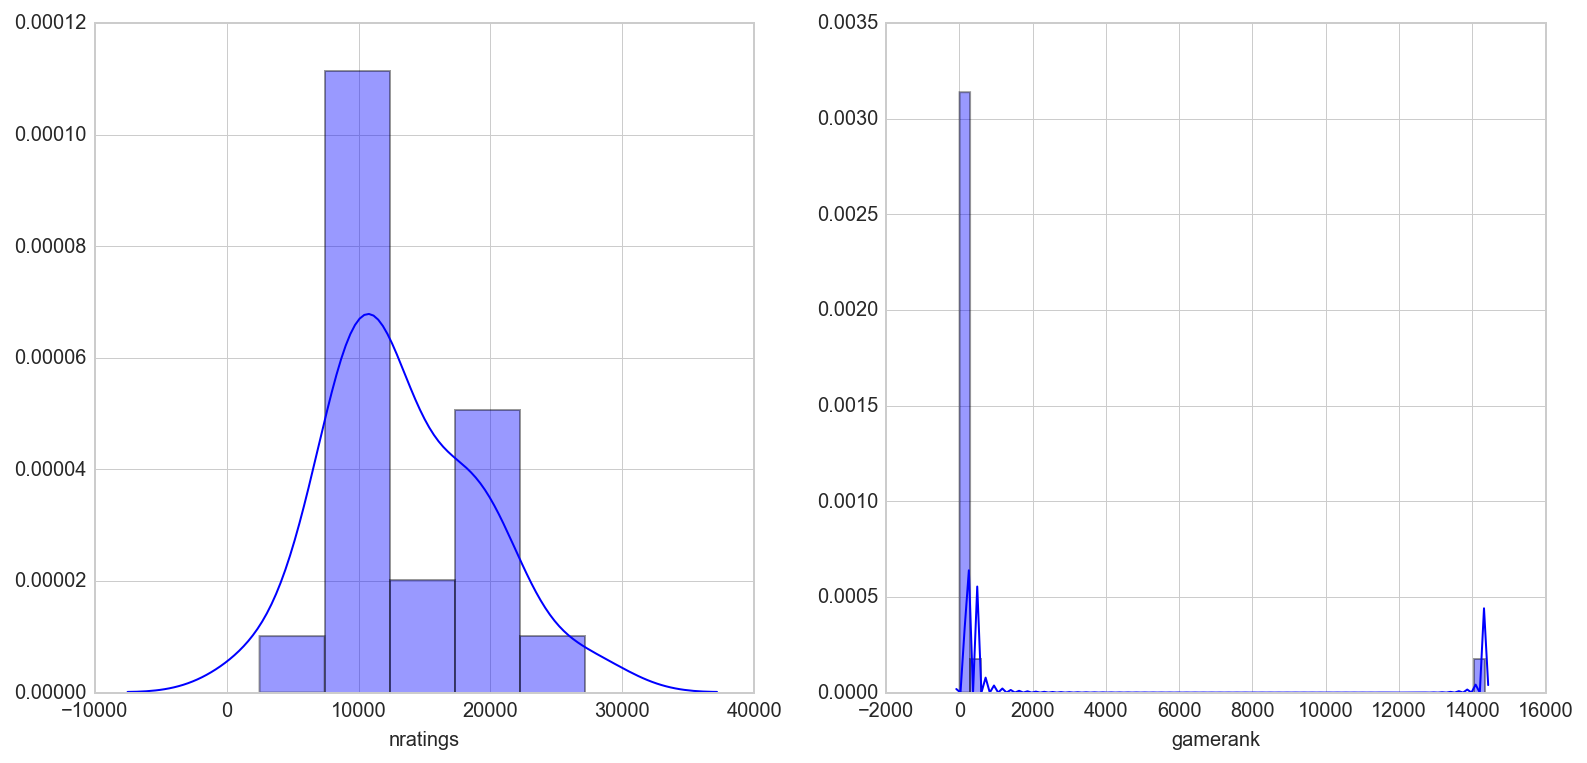

In [134]:
fig, ax = plt.subplots(1,2, figsize=(13,6))
sns.distplot(me_svd_100.head(20)['nratings'], ax=ax[0])
sns.distplot(me_svd_100.head(20)['gamerank'], ax=ax[1])
plt.show()

> The lower end of number of ratings of games in this list seems to have shifted up with the majority beign at the 10,000s range. We can also see the outlier of the last-ranked game of our list that severely skews our gamerank distribution.

> How about training and SVD model with just 10 latent factors?

In [21]:
#Train SVD model with k=10
%time U, sigma, Vt = svd_train.train(k=10)

CPU times: user 34.5 s, sys: 5.84 s, total: 40.4 s
Wall time: 29.1 s


In [22]:
#Make predictions
%time all_preds_svd10_train, test_preds_svd10 = svd_train.predict(U, sigma, Vt, test, mean)

/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:42: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


CPU times: user 24.3 s, sys: 17.4 s, total: 41.7 s
Wall time: 1min 7s


In [23]:
#Evaluate RMSE for k=10
error_svd = svd_train.get_rmse(y, test_preds_svd10)
error_svd

1.2784756733580973

> With 10 latent factors, I get my lowest RMSE score yet. Let's see what games it recommends to me.

In [55]:
#Train SVD model on entire df
%time U, sigma, Vt = svd.train(k=10)

CPU times: user 31.3 s, sys: 2.67 s, total: 34 s
Wall time: 21.6 s


In [56]:
#Predict for entire df
%time all_preds_svd10, test_preds_svd10 = svd.predict(U, sigma, Vt, test, mean)

/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:42: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


CPU times: user 20.3 s, sys: 10.7 s, total: 31.1 s
Wall time: 40.9 s


In [57]:
#Pickle predictions
pd.to_pickle(all_preds_svd10, 'svd10preds_pickle')

In [58]:
#Recommend games for a specific user
%time me_svd_10 = svd.recommend(df, 'Hilaryg', games, all_preds_svd10)

CPU times: user 9.82 ms, sys: 24.4 ms, total: 34.2 ms
Wall time: 63.6 ms


In [59]:
#Displaying top 20 games with k=10
me_svd_10.head(20)

,gameid,gamename,nratings,gamerank,predictions
52,161936,Pandemic Legacy: Season 1,20423,1,8.407412
4,68448,7 Wonders,55341,37,7.813177
5,9209,Ticket to Ride,50968,110,7.527346
19,110327,Lords of Waterdeep,31175,44,7.417455
32,173346,7 Wonders Duel,24654,9,7.410389
15,178900,Codenames,34348,36,7.341506
28,37111,Battlestar Galactica,26374,54,7.300955
53,169786,Scythe,20379,8,7.282874
129,146508,T.I.M.E Stories,12468,35,7.280520
78,170216,Blood Rage,16362,17,7.228432


>The majority of these games are within the top 100 games which suggests that they are highly popular and well-regarded. Let's take a look at the distributions of the number of ratings and gamerank

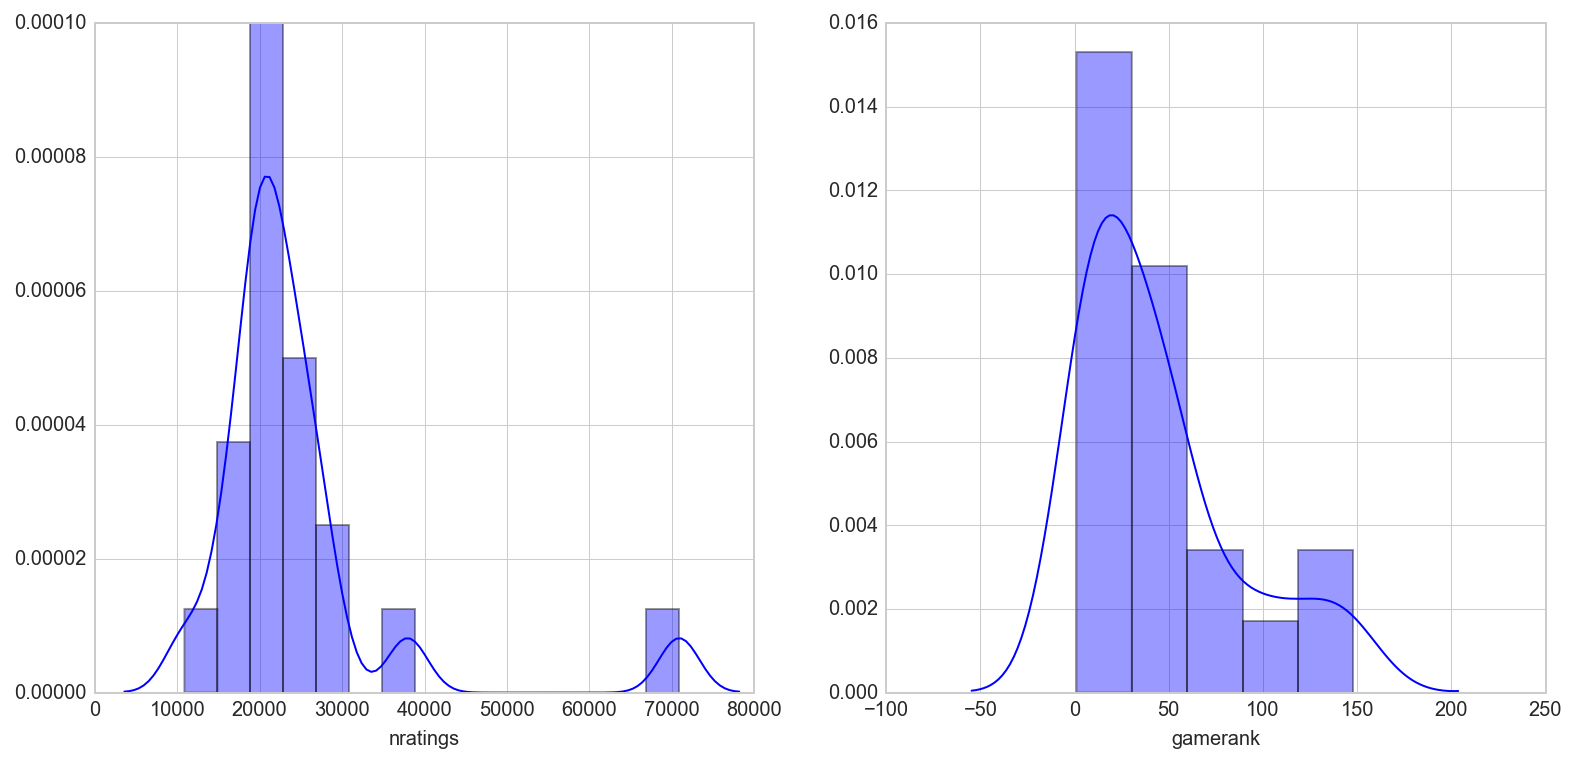

In [141]:
fig, ax = plt.subplots(1,2, figsize=(13,6))
sns.distplot(me_svd_10.head(20)['nratings'], ax=ax[0])
sns.distplot(me_svd_10.head(20)['gamerank'], ax=ax[1])
plt.show()

> As suspected, this list contains the top regarded games on BGG. This can be observd through the smaller range of games recommended in terms of gamerank from 1-150 and the inclusion of a game with a high number of ratings, Carcassone with 70895 ratings to be exact. The lower end of the number of ratings has also shifted to games where at least 10,000 users have rated the game.

### Latent Factor method - Non-Negative Matrix Factorization with Alternating Least Squares
> In this final model, we will attempt to factorize the ratings matrix using the Alternating Least Squares method of minimizing the cost function. It works by holding one set of latent factors, either the user or item vector, constant at any one point in time while solving for the other. It then alternates until convergence to a minimum. As opposed to SVD, bias terms are added to the cost function and eigenvalues are not calculated.

![als algorithm](./assets/als_algo.png)

> A class is built off the base Recommender class and a grid search was applied to find the best hyperparameters of regularization, number of iterations of the alternating least squares step as well as the optimal number of latent factors. 



In [24]:
from numpy.linalg import solve
class ALSMF(Recommender):
    def __init__(self, 
                 ratings, 
                 n_factors=40, 
                 item_reg=0.0, 
                 user_reg=0.0,
                 verbose=False):
        """
        Train a matrix factorization model to predict empty 
        entries in a matrix. The terminology assumes a 
        ratings matrix which is ~ user x item
        
        Params
        ======
        ratings : (ndarray)
            User x Item matrix with corresponding ratings
        
        n_factors : (int)
            Number of latent factors to use in matrix 
            factorization model
        
        item_reg : (float)
            Regularization term for item latent factors
        
        user_reg : (float)
            Regularization term for user latent factors
        
        verbose : (bool)
            Whether or not to printout training progress
        """
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose
        
    def als_step(self, latent_vectors, fixed_vecs, ratings, _lambda, type='user'):
        """
        One of the two ALS steps. Solve for the latent vectors
        specified by type.
        """
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in xrange(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in xrange(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors
    
    def train(self, n_iter=10):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors
        self.user_vecs = np.random.random((self.n_users, self.n_factors))
        self.item_vecs = np.random.random((self.n_items, self.n_factors))
        
        self.partial_train(n_iter)
    
    def partial_train(self, n_iter):
        """ 
        Train model for n_iter iterations. Can be 
        called multiple times for further training.
        """
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print '\tcurrent iteration: {}'.format(ctr)
            self.user_vecs = self.als_step(self.user_vecs, 
                                           self.item_vecs, 
                                           self.ratings, 
                                           self.user_reg, 
                                           type='user')
            self.item_vecs = self.als_step(self.item_vecs, 
                                           self.user_vecs, 
                                           self.ratings, 
                                           self.item_reg, 
                                           type='item')
            ctr += 1
    
    def predict(self, test, mean):
        """ 
        Predicts ratings based on user and 
        item latent factors 
        """
        all_predictions = self.user_vecs.dot(self.item_vecs.T) + mean.reshape(-1, 1)
        test_predictions = all_predictions[test.fillna(0).as_matrix().nonzero()]
        return all_predictions, test_predictions
    
    def recommend(self, ratings, user, games, predictions):
        '''
        Provides recommendations for the specified user
        
        Params
        ======
        user : (string)
            username with at least 10 ratings in database
        
        games : (Dataframe)
            Dataframe of game list
        
        predictions : (nd_array)
            predictions of entire ratings matrix
        '''
        user_idx = ratings.index.get_loc(user)
        preds = predictions[user_idx]
        rated = ratings.loc[user].fillna(0).as_matrix().nonzero()

        mask = np.ones_like(preds, dtype=bool)
        mask[rated] = False
        preds[~mask] = 0

        predictions = pd.Series(preds, index=ratings.columns, name='predictions')
        recommendations = games.join(predictions, on='gameid')
        return recommendations.sort_values('predictions', ascending=False) 

In [36]:
#Gridsearch of best parameters for ALS matrix factorization of ratings matrix
%%time
latent_factors = [5, 10, 20]
regularizations = [0.1, 1., 10., 100.]
regularizations.sort()
iter_array = [1, 10, 40]

best_params = {}
best_params['n_factors'] = latent_factors[0]
best_params['reg'] = regularizations[0]
best_params['n_iter'] = 0
best_params['test_rmse'] = np.inf
best_params['model'] = None

for fact in latent_factors:
    print 'Factors: {}'.format(fact)
    for reg in regularizations:
        print 'Regularization: {}'.format(reg)
        for itera in iter_array:
            print 'Iterations: {}'.format(itera)
            MF_ALS = ALSMF(train_normed, n_factors=fact, \
                                user_reg=reg, item_reg=reg)
            MF_ALS.train(n_iter = itera)
            all_predictions, test_predictions = MF_ALS.predict(test, mean)
            test_rmse = MF_ALS.get_rmse(y, test_predictions)
            if test_rmse < best_params['test_rmse']:
                best_params['n_factors'] = fact
                best_params['reg'] = reg
                best_params['n_iter'] = itera
                best_params['test_rmse'] = test_rmse
                best_params['model'] = MF_ALS
                print 'New optimal hyperparameters'
                print pd.Series(best_params)

Factors: 5
Regularization: 0.1
Iterations: 1


/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:96: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


New optimal hyperparameters
model        <__main__.ALSMF object at 0x122e40b10>
n_factors                                         5
n_iter                                            1
reg                                             0.1
test_rmse                                   1.32028
dtype: object
Iterations: 10
New optimal hyperparameters
model        <__main__.ALSMF object at 0x100744310>
n_factors                                         5
n_iter                                           10
reg                                             0.1
test_rmse                                   1.28112
dtype: object
Iterations: 40
New optimal hyperparameters
model        <__main__.ALSMF object at 0x122e44250>
n_factors                                         5
n_iter                                           40
reg                                             0.1
test_rmse                                   1.28057
dtype: object
Regularization: 1.0
Iterations: 1
Iterations: 10
Iterations: 40


> We see that the best parameters are 40 iterations, of 10 factors with a regularization value of 0.1 in order to achieve an RMSE of 1.27808. 

In [25]:
#Instatiate ALSMF class
als_train = ALSMF(train_normed, n_factors=10, item_reg=0.1, user_reg=0.1)

In [26]:
#Train model 
%time als_train.train(40)

CPU times: user 8min 41s, sys: 6.56 s, total: 8min 47s
Wall time: 8min 59s


In [27]:
#Make predictions for test set
%time all_preds_train, test_preds_train = als_train.predict(test, mean)

/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:96: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


CPU times: user 18.9 s, sys: 10.6 s, total: 29.5 s
Wall time: 35.1 s


In [28]:
#Evaluate RMSE on test set
error_als = als.get_rmse(y, test_preds_train)
error_als

NameError: name 'als' is not defined

> The error looks to be the lowest yet. We will do a comparison below across the different models. Before that, let's look at the recommendations generated by this model.

In [32]:
#Instatiate ALSMF class for full data
als = ALSMF(df_normed, n_factors=10, item_reg=0.1, user_reg=0.1)

In [33]:
#Train model on whole dataset
%time als.train(40)

CPU times: user 8min 48s, sys: 5.79 s, total: 8min 54s
Wall time: 9min 8s


In [34]:
#Save model to pickle
pd.to_pickle(als, 'alsmodel_pickle')

In [35]:
#Make predictions for entire dataset
%time all_preds, test_preds= als_train.predict(test, mean)

/Users/timmoti/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:96: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


CPU times: user 19.7 s, sys: 10.4 s, total: 30.1 s
Wall time: 37.5 s


In [36]:
#Save predictions to pickle
pd.to_pickle(all_preds, 'alspreds_pickle')

In [38]:
#Predict for a specified user
me_als = als.recommend(df, 'passthedynamite', games, all_preds)
me_als.head(20)

,gameid,gamename,nratings,gamerank,predictions
33,40834,Dominion: Intrigue,24025,51,8.394050
1,822,Carcassonne,70895,130,7.777819
34,463,Magic: The Gathering,23999,148,7.671080
52,161936,Pandemic Legacy: Season 1,20423,1,7.621510
24,12333,Twilight Struggle,28657,3,7.621337
13,14996,Ticket to Ride: Europe,37944,85,7.601219
89,25613,Through the Ages: A Story of Civilization,15699,18,7.598921
43,124742,Android: Netrunner,21275,33,7.582674
59,35677,Le Havre,19825,31,7.565839
38,18602,Caylus,22461,40,7.545787


> Much like the SVD model with 10 latent factors , the results for this list of 20 consists of games that are high in the board game geek rankings and looks very similar to that list.

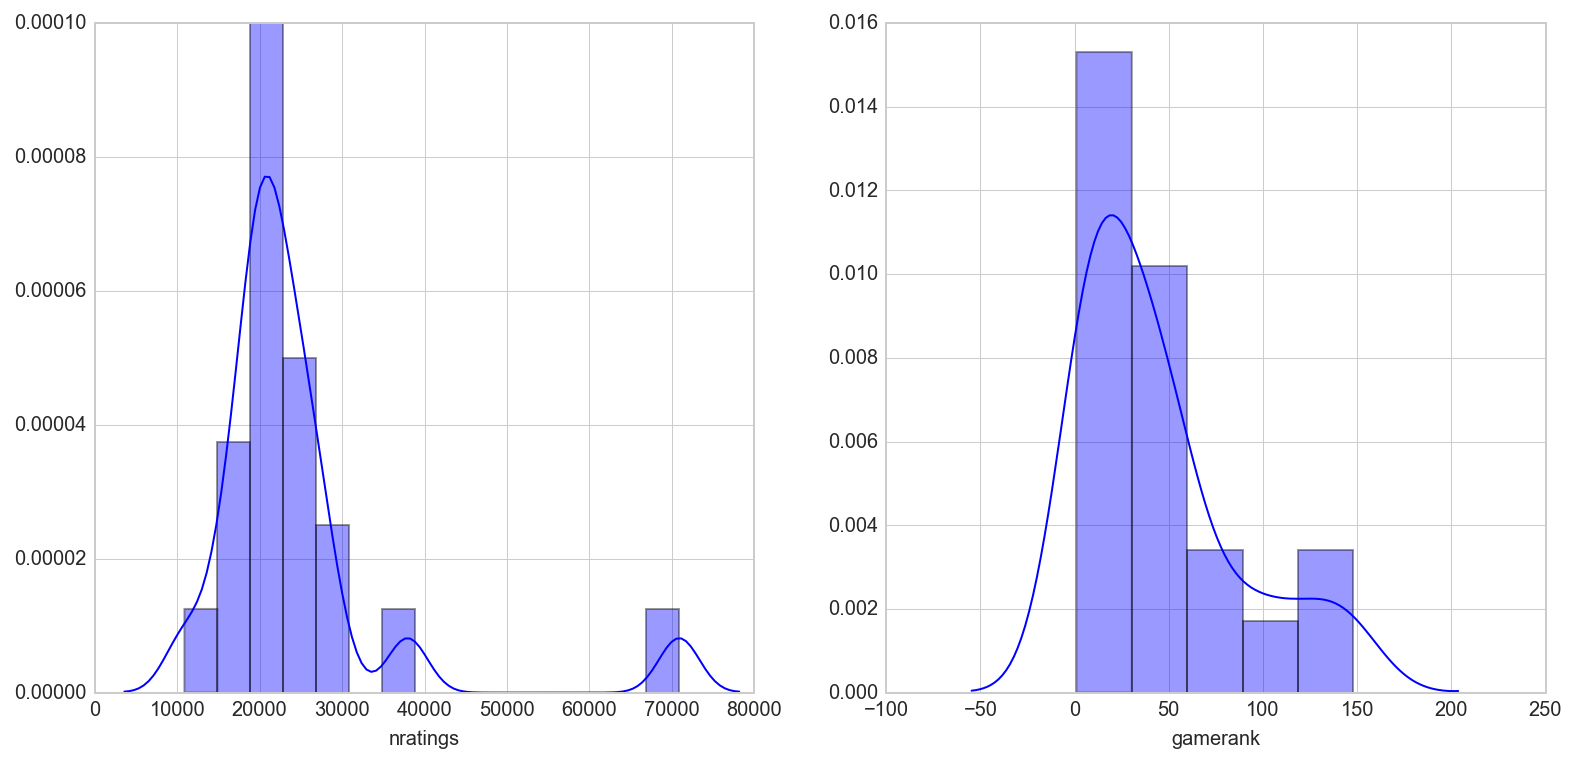

In [156]:
fig, ax = plt.subplots(1,2, figsize=(13,6))
sns.distplot(me_als.head(20)['nratings'], ax=ax[0])
sns.distplot(me_als.head(20)['gamerank'], ax=ax[1])
plt.show()

> The plots for the non-negative matrix factorization model looks just like that for SVD with 10 latent factors

In [ ]:
#Comparison of RMSE across models
pd.DataFrame()

## Which model to choose?
> We have seen the results of the recommendations and the RMSE scores. Judging solely by the RMSE scores we are inclined to conclude that matrix factorization with 10 latent factors (SVD or NNMF) yields the most accurate scores. However, the top 20 lists they produce seem to only include games that are already popular on the website, which begs the question, what determines popularity of a game, the number of ratings or its rank?

In [ ]:
df[13].mean()

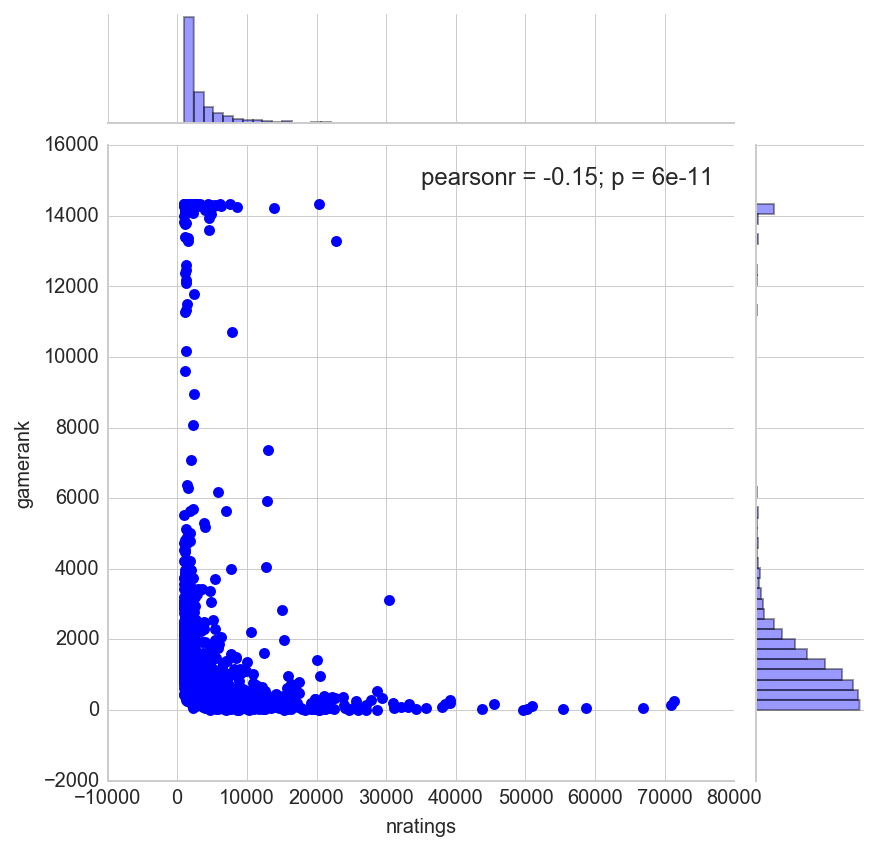

In [170]:
#Plot scatterplot of number of ratings vs gamerank
sns.jointplot(games['nratings'], games['gamerank'])
plt.show()

> A quick look at the correlation between both variables suggests that there is little to no correlation between a game's rank and how many users have rated it. That being said, we can observe that the most rated games tend to trend near the top of the rankings. It is safe to say that both measures determine a game's popularity.     

> Users that rate games on the site are quite a serious bunch and most likely would have looked for games via the ranking system first. The thing is, not all games on the top 100-200 will appeal to everyone and there is merit to recommending popular games that you will likely enjoy. However, the sense of serendipity is not there with lists that are too 'rigid' in their presentation. I was actually pleasantly surprised to discover a new game that was recommended to me via the 'lesser' cosine similarity algorithm.

> The quality of a board game recommender system also depends on what it is positioned to accomplish. If it is to help one narrow down the choices of games to play or purchase next, it would seem that having high accuracy on the most popular games would help. On the other hand, if it is to discover new games on a regular basis, a less accurate but more serendipitous version would be ideal.

> An ideal boardgame recommender system for BoardGameGeek users, at least to me personally, would be one that recommends me games from the popular bunch to look out for but also throws in some surprises with games that are further down the ranking order. Perhaps even 2 sets of top 20s with explanations such as "High-ranked games you might like' and 'Hidden gems similar to your taste'

## One last thing

> Recommender systems are as much an art as a science. Getting the best offline scores might not necessarily translate to consumer satisfaction. A good recommender system should get to know the end user really well over time but not too well. It is somewhat analagous to a marriage. Too much knowledge and understanding can lead to boredom. 

>In my opinion, a good recommender system should adjust its recommendations based on factors like context and time, creating somewhat of a snowball effect as the user continues using it. It takes some skill in deciding what items to display for serendipity, how often to display them, when to display them and at what percentage of the list. 

>Ultimately it should gain the trust of the user while keeping things fresh.

## What's next?
> In part 3, we will be building a web app using flask, deploy it to the cloud and possibly get some online evaluation from actual Boardgamegeek users. 

> As for further modeling work, here are some areas that can be further investigated.
1. Acquire game features and build a content-based filtering recommender
2. Evaluate with ranking metrics such as Mean Average Precision @ k
3. Modeling with a graph-based network like neo4j
4. Apply wide and deep learning for better memorization and generalization
5. Explore the application of a hybrid recommender model
6. Explore group recommendations which aggregates a group's gaming interests together to recommend games
7. Assess a computationally less expensive approach to user-user cosine similarity